---

# InClass Kaggle Competition - Example - Python - v5.2

This notebook gives an example on the implementation of machine learning pipeline for the InClass Kaggle Competition.

Last update on: 05/04/2021

---

The machine learning pipeline includes:

1. Data processing (Part 2)
- [x] Error correction
- [x] Feature engineering
- [x] Value transformation
- [x] Value representation
- [x] Variable selection

2. Modeling (Part 3)
- [x] Logistic Regression, Random Forest, XGBoost
- [x] Hyper parameter tuning

3. Experimental setup (Part 3)
- [x] k-fold CV
- [x] Oversampling [DROPPED]

4. Debuging (Part 3)
- [x] Analyzing k-fold CV
- [x] Learning curve

In [1]:
%%time
# Version
exp_version = 'v5.3'  # Experiment version
data_prep = 'std'  # full = data transformation, representation, std = standard, only dummy encode
var_set = 'all'  # all = all vars, fs = top fisher score, pca = first PCs
fname = '_' + data_prep + '_' + var_set + '_' + exp_version  # Name of output file
print(fname)

_std_all_v5.3
Wall time: 1.03 ms


In [2]:
%%time
# Flag variables to run the data processing steps
# Feature engineering step
enable_num_poly = False  # Add polynomial terms
# Value transformation step
enable_trans_cat_dt = False  # Remapping cat variables - Decision tree–based remapping
enable_trans_num_dt = False  # Discretizing num variables - Decision tree–based discretization
enable_trans_num_ef = False  # Discretizing num variables - Equal frequency discretization
enable_trans_num_ew = False  # Discretizing num variables - Equal width discretization
# Value representation step
enable_repr_dummy = True  # Represent cat variables - Dummy coding
enable_repr_icd = False  # Represent cat variables - Incidence (of target variable) replacement
enable_repr_woe = False  # Represent cat variables - Weight-of-Evidence (WoE) conversion
drop_cat_vars = True  # Drop cat variables after value representation step
# Other data processing
enable_normalize = True  # Normalize the data to the same range [0, 1]

Wall time: 0 ns


## Initiation

In [3]:
%%time
# Data exploration
import matplotlib.pyplot as plt

# Data processing
import pickle
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

# Experimental setup
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve

Wall time: 4.59 s


## 1. Data summary

#### (a) Read and print out some data

In [4]:
%%time
# Read train, test
train = pd.read_csv('./data/processed/kaggle/orange_churn_train.csv', low_memory=False)
test = pd.read_csv('./data/processed/kaggle/orange_churn_test.csv', low_memory=False)

Wall time: 712 ms


In [5]:
%%time
# Print out to check the data
print(train.dtypes.value_counts())
train.head()

float64    191
object      38
int64        3
dtype: int64
Wall time: 2.01 ms


,cust_id,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,churn
0,3,NaN,NaN,NaN,NaN,NaN,1351.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,7P5s,ZI9m,NoEd,mj86,NaN,0
1,4,NaN,NaN,NaN,NaN,NaN,644.0,0.0,NaN,NaN,...,76DJixu,LM8l689qOp,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,NaN,0
2,7,NaN,NaN,NaN,NaN,NaN,2583.0,0.0,NaN,NaN,...,I5dzv5f,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN,1
3,8,NaN,NaN,NaN,NaN,NaN,1463.0,7.0,NaN,NaN,...,xwyAw04,LM8l689qOp,NaN,kG3k,fKCe,RAYp,F2FyR07IdsN7I,mj86,NaN,0
4,9,NaN,NaN,NaN,NaN,NaN,77.0,0.0,NaN,NaN,...,76DJixu,NaN,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,NaN,0


#### (b) Create a list of column names to manage variables

In [6]:
%%time
# List of numerical and catergorical variables
id_var = ["cust_id"]  # ID
num_vars = train.columns[1:191].tolist()  # First 190 vars
cat_vars = train.columns[191:231].tolist()  # Last 40 vars
# Target get variable
target_var = ["churn"]

Wall time: 0 ns


#### (c) Check the target variable class distribution

In [7]:
%%time
# By number
print(train[target_var].value_counts())
# By percentage
print(train[target_var].value_counts(normalize=True))

churn
0        9264
1         736
dtype: int64
churn
0        0.9264
1        0.0736
dtype: float64
Wall time: 8.98 ms


## 2. Processing data

### 2.1. Error, data correction

#### (a) Check and correct data error - Constant variables

Constant variables on train do not contain information and may cause data processing or model training error.

In [8]:
%%time
# Count number of unique values of each variable
vars_nunique = train[num_vars + cat_vars].apply(pd.Series.nunique, dropna=False, axis=0)
cont_vars = vars_nunique.index[vars_nunique < 2].tolist()
print("Drop constant variable:", cont_vars)
# Correct variable list
num_vars = [v for v in num_vars if v not in cont_vars]
cat_vars = [v for v in cat_vars if v not in cont_vars]
# Update train, test
train = train[id_var + num_vars + cat_vars + target_var]
test = test[id_var + num_vars + cat_vars]

Drop constant variable: ['Var8', 'Var15', 'Var20', 'Var31', 'Var32', 'Var39', 'Var42', 'Var48', 'Var52', 'Var55', 'Var79', 'Var141', 'Var167', 'Var169', 'Var175', 'Var185', 'Var209', 'Var230']
Wall time: 134 ms


#### (b) Check and correct data error - Missing values

<u>Note:</u>
- Always create indicators (dummy variable) to track the missing values imputation.
- Since we already filtered out the constant NA vars, the imputor will not drop any vars.

In [9]:
%%time
# Check missing value
print('Train - # NA of num vars:', train[num_vars].isna().sum().sum())
print('Train - # NA of cat vars:', train[cat_vars].isna().sum().sum())
print('Test - # NA of num vars:', test[num_vars].isna().sum().sum())
print('Test - # NA of cat vars:', test[cat_vars].isna().sum().sum())

Train - # NA of num vars: 1345535
Train - # NA of cat vars: 79067
Test - # NA of num vars: 1345234
Test - # NA of cat vars: 79296
Wall time: 82 ms


In [10]:
# %%time
# # Here, we test the effect of dropping variables with high missing percentage (>30%)
# # Drop num variables with more than 30% missing values
# num_na_pct = train[num_vars].isnull().mean()
# num_vars = num_na_pct[num_na_pct <= 0.3].index.tolist()
# # Drop cat variables with more than 30% missing values
# cat_na_pct = train[cat_vars].isnull().mean()
# cat_vars = cat_na_pct[cat_na_pct <= 0.3].index.tolist()
# # Update train, test
# train = train[id_var + num_vars + cat_vars + target_var]
# test = test[id_var + num_vars + cat_vars]

In [11]:
%%time
# List dummary variables to track missing values imputation
na_vars = []

Wall time: 0 ns


In [12]:
%%time
# Numerical variables
# Build the missing value imputor using the mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
imp.fit(train[num_vars])
# Reconstruct the list of vars + indicators
na_vars = na_vars + [num_vars[v] + "_na" for v in imp.indicator_.features_]
impute_vars = num_vars + na_vars
# Apply on train, test
train[impute_vars] = pd.DataFrame(imp.transform(train[num_vars]), columns=impute_vars)
test[impute_vars] = pd.DataFrame(imp.transform(test[num_vars]), columns=impute_vars)

Wall time: 560 ms


In [13]:
%%time
# Categorical variables
# Impute missing value using a new category "Missing"
# Note: If the categorical vars are imputed by most_frequent, the indicators should be added
train[cat_vars] = train[cat_vars].fillna('Missing')
test[cat_vars] = test[cat_vars].fillna('Missing')

Wall time: 143 ms


#### (c) Check and correct data error - Outliers in numerical variables

Here, we only check but not impute the outliers.

<u>Note:</u>
- Before correcting outliers, make sure to understand the nature of the error.
- Do not need to correct outliers for missing values indicators.

In [14]:
%%time
# Check the outliers on train, test
for v in num_vars:
    # Calculate the boundaries on train [mean-3*sd, mean+3*sd]
    mu = np.mean(train[v])
    sd = np.std(train[v])
    lower = mu - 3*sd
    upper = mu + 3*sd
    # Check outliers using the boundaries
    train_out = (train[v] < lower) | (train[v] > upper)
    test_out = (test[v] < lower) | (test[v] > upper)
    if np.sum(train_out) + np.sum(test_out) > 0:
        print(v, "has # outliers on train, test :",
              np.sum(train_out), "[", np.round(100*np.mean(train_out), 2), "% ]",
              np.sum(test_out), "[", np.round(100*np.mean(test_out), 2), "% ]")

Var1 has # outliers on train, test : 21 [ 0.21 % ] 21 [ 0.21 % ]
Var3 has # outliers on train, test : 12 [ 0.12 % ] 3 [ 0.03 % ]
Var4 has # outliers on train, test : 2 [ 0.02 % ] 3 [ 0.03 % ]
Var5 has # outliers on train, test : 27 [ 0.27 % ] 29 [ 0.29 % ]
Var6 has # outliers on train, test : 85 [ 0.85 % ] 85 [ 0.85 % ]
Var7 has # outliers on train, test : 214 [ 2.14 % ] 190 [ 1.9 % ]
Var9 has # outliers on train, test : 66 [ 0.66 % ] 76 [ 0.76 % ]
Var10 has # outliers on train, test : 37 [ 0.37 % ] 32 [ 0.32 % ]
Var11 has # outliers on train, test : 18 [ 0.18 % ] 14 [ 0.14 % ]
Var12 has # outliers on train, test : 75 [ 0.75 % ] 81 [ 0.81 % ]
Var13 has # outliers on train, test : 85 [ 0.85 % ] 72 [ 0.72 % ]
Var14 has # outliers on train, test : 14 [ 0.14 % ] 11 [ 0.11 % ]
Var16 has # outliers on train, test : 200 [ 2.0 % ] 174 [ 1.74 % ]
Var17 has # outliers on train, test : 32 [ 0.32 % ] 37 [ 0.37 % ]
Var18 has # outliers on train, test : 12 [ 0.12 % ] 18 [ 0.18 % ]
Var19 has # outlie

Var139 has # outliers on train, test : 42 [ 0.42 % ] 46 [ 0.46 % ]
Var140 has # outliers on train, test : 178 [ 1.78 % ] 186 [ 1.86 % ]
Var142 has # outliers on train, test : 125 [ 1.25 % ] 141 [ 1.41 % ]
Var143 has # outliers on train, test : 66 [ 0.66 % ] 93 [ 0.93 % ]
Var144 has # outliers on train, test : 223 [ 2.23 % ] 220 [ 2.2 % ]
Var145 has # outliers on train, test : 26 [ 0.26 % ] 29 [ 0.29 % ]
Var146 has # outliers on train, test : 28 [ 0.28 % ] 12 [ 0.12 % ]
Var147 has # outliers on train, test : 160 [ 1.6 % ] 147 [ 1.47 % ]
Var148 has # outliers on train, test : 33 [ 0.33 % ] 36 [ 0.36 % ]
Var149 has # outliers on train, test : 118 [ 1.18 % ] 129 [ 1.29 % ]
Var150 has # outliers on train, test : 44 [ 0.44 % ] 41 [ 0.41 % ]
Var151 has # outliers on train, test : 113 [ 1.13 % ] 121 [ 1.21 % ]
Var152 has # outliers on train, test : 131 [ 1.31 % ] 138 [ 1.38 % ]
Var154 has # outliers on train, test : 102 [ 1.02 % ] 125 [ 1.25 % ]
Var155 has # outliers on train, test : 27 [ 0.27

#### (d) Encode categorical variables

In Python, most of the machine learning libraries will not handle non-numerical values of categorical varibales (e.g. RF). Therefore, we should encoded the categories using integer values.

<u>Note:</u>
- Here, the encoder is fitted on both train and test. Therefore, in a few special cases, there are unique categories that appear only on train, or test.

In [80]:
# %%time
# # Keep top 10 categories and combine minor categories into "Others"
# for v in cat_vars:
#     # Find the top 10 categories per cat variable
#     top10_cat = train[v].value_counts()[:10].index.tolist()
#     # Impute on train, test
#     train[v][-train[v].isin(top10_cat)] = 'Others'
#     test[v][-test[v].isin(top10_cat)] = 'Others'

In [16]:
%%time
# Encode categorical variables as integer values
# Note: All the NA values were imputed previously
enc = OrdinalEncoder()
enc.fit(pd.concat([train[cat_vars], test[cat_vars]], axis=0))
# Apply on train, test
train[cat_vars] = enc.transform(train[cat_vars])
test[cat_vars] = enc.transform(test[cat_vars])

Wall time: 532 ms


#### (e) Finalize the processed data

Current lists of variables:
- id_var : customer ID
- num_vars : numerical variables
- cat_vars : categorical variables
- na_vars : indicators for tracking missing values, bool [False, True]
- target_var : target variable, churn [0, 1]

<u>Note:</u> If there are any variables exist in only train or test, drop them from all the data.

In [17]:
%%time
# Convert bool variable to int
train[na_vars] = train[na_vars].astype(np.int8)
test[na_vars] = test[na_vars].astype(np.int8)

Wall time: 4.41 s


In [18]:
%%time
# Print out the final variables
print("# id_var [", len(id_var), "] :", id_var)
print("# num_vars [", len(num_vars), "] :", num_vars[:5], "...")
print("# cat_vars [", len(cat_vars), "] :", cat_vars[:5], "...")
print("# na_vars [", len(na_vars), "] :", na_vars[:5], "...")
print("# target_var [", len(target_var), "] :", target_var)

# id_var [ 1 ] : ['cust_id']
# num_vars [ 174 ] : ['Var1', 'Var2', 'Var3', 'Var4', 'Var5'] ...
# cat_vars [ 38 ] : ['Var191', 'Var192', 'Var193', 'Var194', 'Var195'] ...
# na_vars [ 171 ] : ['Var1_na', 'Var2_na', 'Var3_na', 'Var4_na', 'Var5_na'] ...
# target_var [ 1 ] : ['churn']
Wall time: 1.03 ms


In [19]:
%%time
# Sort the data according to the variables list
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(10000, 385)
(10000, 384)
Wall time: 53 ms


### 2.2. Feature engineering

Since every variables are anonymized, we cannot create new variables based the meaning of current variables.

In other case, we can use the following hints:
- Quickly check the potentially important variables.
- Focus on the most important variables to create new variables.
- Create a cross variable framework (e.g. customer activities, date-time, events, etc.) for searching the new variables.

#### (a) Quickly detect most (potentially) important varriables - Correlation test for numerical variables

In [20]:
%%time
# Pearson's correlation for numerical variables
corr = train[num_vars + target_var].corr(method='pearson')
corr = corr['churn'][:-1].dropna()
print("Top 5 vars [+] correlated with target var :"); print(corr.sort_values(ascending=False)[:5])
print("Top 5 vars [-] correlated with target var :"); print(corr.sort_values(ascending=True)[:5])

Top 5 vars [+] correlated with target var :
Var113    0.054660
Var131    0.033685
Var126    0.030609
Var173    0.029983
Var81     0.028262
Name: churn, dtype: float64
Top 5 vars [-] correlated with target var :
Var189   -0.087654
Var73    -0.073407
Var7     -0.059302
Var65    -0.047361
Var13    -0.039086
Name: churn, dtype: float64
Wall time: 1.04 s


#### (b) Quickly detect most (potentially) important varriables - Mutual information

<u>Reference:</u>
- Mutual information. Link: https://en.wikipedia.org/wiki/Mutual_information
- sklearn.feature_selection.mutual_info_classif. Link: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html

In [21]:
%%time
# Check mutual information for all variables
# Note: The calculation involves a random process, therefore, the result may change if there is no
# variable with significant information.
mutual_info = mutual_info_classif(train[cat_vars], train[target_var].values.squeeze())
mutual_info = pd.Series(mutual_info, index=cat_vars)
print("Top 10 vars :"); print(mutual_info.sort_values(ascending=False)[:10])

Top 10 vars :
Var217    0.009080
Var212    0.007863
Var218    0.005646
Var200    0.005069
Var192    0.004683
Var193    0.004396
Var216    0.003988
Var204    0.003896
Var224    0.003443
Var206    0.003382
dtype: float64
Wall time: 4.21 s


#### (c) Add polynomial terms for numerical variables

<u>Note:</u> We only add the polynomial terms (degree=3) for a num variable if it increases the LR model performance.

In [22]:
%%time
if enable_num_poly:
    for v in num_vars:
        # Setup the LR model
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = LogisticRegression(max_iter=200)
        parameters = {}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        
        # Fit the LR model for 1 numerical variable
        clf.fit(train[[v]], train[target_var].squeeze())
        clf_num_score = clf.best_score_
        
        # Fit the LR model for 1 numerical variable + it polynomial degree = 3
        poly = PolynomialFeatures(degree=3, include_bias=False)
        poly.fit(train[[v]])
        clf.fit(poly.transform(train[[v]]), train[target_var].squeeze())
        clf_poly_score = clf.best_score_
        
        # Add the polynomial terms to train, test
        if (clf_poly_score > 0.5) & (clf_poly_score - clf_num_score > 0.05):
            print('Variable', v, 'AUC vs. AUC poly:', clf_num_score, '-->', clf_poly_score)
            poly_vars = [v_poly.replace('x0', v) for v_poly in poly.get_feature_names()[1:]]
            num_vars = num_vars + poly_vars
            train[poly_vars] = pd.DataFrame(poly.transform(train[[v]])[:, 1:], columns=poly_vars)
            test[poly_vars] = pd.DataFrame(poly.transform(test[[v]])[:, 1:], columns=poly_vars)

Wall time: 0 ns


### 2.3. Value transformation (num, cat => cat)

- Categorical variable: remapping
- Continuous variable: discretization

<u>Note:</u> Some techniques that incoporate the information from target variable may cause overfitting problem.

<u>Reference:</u>

- Coussement, K., Lessmann, S., & Verstraeten, G. (2017). A comparative analysis of data preparation algorithms for customer churn prediction: A case study in the telecommunication industry. Decision Support Systems, 95, 27-36.

In [23]:
%%time
# List of variables to track the value transformation process
trans_vars = []

Wall time: 0 ns


#### 2.3.1. Remapping categorical variables - Decision tree–based remapping

#### (a) Test the variable remmaping on a categorical variable

In [24]:
%%time
# Select a variable
v = "Var217"

# Find the best decision tree
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = DecisionTreeClassifier()
parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
clf.fit(train[[v]], train[target_var])
print("Best AUC:", clf.best_score_)
print("Best params:", clf.best_params_)
print("Number of leaves:", clf.best_estimator_.get_n_leaves())

Best AUC: 0.5272502800324675
Best params: {'min_samples_leaf': 100}
Number of leaves: 4
Wall time: 6.21 s


In [25]:
%%time
# Grouping the categories into new categories (leaves) using Decision Tree
# Here, we use the decision path, the last node is the new segment of an observation
remap_v = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]

print("# original categories:", train[[v]].nunique().values[0])
print("# new remapped categories:", len(set(remap_v)), set(remap_v))

# original categories: 11
# new remapped categories: 4 {2, 3, 5, 6}
Wall time: 65 ms


#### (b) Apply the variable remmaping for all categorical variables

<u>Note:</u> Only remap the variables if AUC > 0.5 and the number of new categories > 1.

In [26]:
%%time
if enable_trans_cat_dt:
    for v in cat_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(train[[v]], train[target_var])
        # Remap the variable on train, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Remapping variable", v,
                  "from", train[[v]].nunique().values[0],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_remap'
            trans_vars.append(remap_var)
            train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]
            test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(test[[v]]).toarray()]

Wall time: 0 ns


#### 2.3.2. Discretizing (or binning) numerical variables - Decision tree–based discretization

#### (a) Test the variable discretizing on a numerical variable

In [27]:
%%time
# Select a variable
v = "Var6"

# Find the best decision tree
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = DecisionTreeClassifier()
parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
clf.fit(train[[v]], train[target_var])
print("Best AUC:", clf.best_score_)
print("Best params:", clf.best_params_)
print("Number of leaves:", clf.best_estimator_.get_n_leaves())

Best AUC: 0.5589419285653838
Best params: {'min_samples_leaf': 1000}
Number of leaves: 7
Wall time: 168 ms


In [28]:
%%time
# Grouping the categories into new categories (leaves) using Decision Tree
# Here, we use the decision path, the last node is the new segment of an observation
remap_v = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]

print("# original data range: ", [train[[v]].min().values[0], train[[v]].max().values[0]])
print("# new remapped categories:", len(set(remap_v)), set(remap_v))

# original data range:  [0.0, 114079.0]
# new remapped categories: 7 {3, 4, 6, 8, 9, 11, 12}
Wall time: 67 ms


#### (b) Apply the variable discretizing for all numerical variables

<u>Note:</u> Only bin/discretize the variables if the number of new categories > 1.

In [29]:
%%time
if enable_trans_num_dt:
    for v in num_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(train[[v]], train[target_var])
        # Remap the variable on train, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Discretize variable", v,
                  "from", [train[[v]].min().values[0], train[[v]].max().values[0]],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_bin'
            trans_vars.append(remap_var)
            train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]
            test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(test[[v]]).toarray()]

Wall time: 0 ns


#### 2.3.3. Discretizing (or binning) numerical variables - Equal frequency discretization

<u>Note:</u>  
- According to Coussement, Lessmann, & Verstraeten (2017), the number of bins at 10 is optimal. However, we can also test with different values in the range [5, 10].

#### (a) Test the variable discretizing on a numerical variable

In [30]:
%%time
# Select a variable
v = "Var38"

# Binning values of a variable into new groups using equal frequency approach
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
est.fit(train[[v]])
print("Number of bins :", est.n_bins_[0])
est.bin_edges_

Number of bins : 9
Wall time: 6 ms


C:\tools\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


array([array([0.0000000e+00, 1.3056000e+03, 6.3534600e+04, 5.4795360e+05,
       2.0273880e+06, 2.5428557e+06, 3.5213070e+06, 4.8254844e+06,
       6.7276680e+06, 1.7127060e+07])], dtype=object)

In [31]:
%%time
# Apply the binning to a variable
binef_v = est.transform(train[[v]])
pd.DataFrame(binef_v).value_counts().sort_index()

Wall time: 8.02 ms


0.0    2000
1.0    1000
2.0    1000
3.0    1000
4.0     326
5.0    1674
6.0    1000
7.0    1000
8.0    1000
dtype: int64

#### (b) Apply the variable discretizing for all numerical variables

In [32]:
%%time
if enable_trans_num_ef:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        est.fit(train[[v]])
        # Bin the variable on train, test
        if est.n_bins_[0] > 1:
            binef_var = v + '_binef'
            trans_vars.append(binef_var)
            train[binef_var] = est.transform(train[[v]])
            test[binef_var] = est.transform(test[[v]])

Wall time: 0 ns


#### 2.3.4. Discretizing (or binning) numerical variables - Equal width discretization

#### (a) Test the variable discretizing on a numerical variable.

In [33]:
%%time
# Select a variable
v = "Var38"

# Binning values of a variable into new groups using equal width approach
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
est.fit(train[[v]])
print("Number of bins :", est.n_bins_[0])
est.bin_edges_

Number of bins : 10
Wall time: 3.97 ms


array([array([       0.,  1712706.,  3425412.,  5138118.,  6850824.,  8563530.,
       10276236., 11988942., 13701648., 15414354., 17127060.])],
      dtype=object)

In [34]:
%%time
# Apply the binning to a variable
binew_v = est.transform(train[[v]])
pd.DataFrame(binew_v).value_counts().sort_index()

Wall time: 6.98 ms


0.0    4811
1.0    2127
2.0    1253
3.0     870
4.0     479
5.0     280
6.0     156
7.0      13
8.0       7
9.0       4
dtype: int64

#### (b) Apply the variable discretizing for all numerical variables

In [35]:
%%time
if enable_trans_num_ew:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
        est.fit(train[[v]])
        # Bin the variable on train, test
        if est.n_bins_[0] > 1:
            binew_var = v + '_binew'
            trans_vars.append(binew_var)
            train[binew_var] = est.transform(train[[v]])
            test[binew_var] = est.transform(test[[v]])

Wall time: 0 ns


#### 2.3.5. Finalize value transformation

- Finalize the variables list
- Arrange the data columns

<u>Note:</u> After the end of the value transformation step, we have these final lists of variables to manage:
- num_vars
- na_vars
- cat_vars = cat_vars + trans_vars

In [36]:
%%time
# Finalize the variable list
cat_vars = cat_vars + trans_vars
print("Transformed num, cat variables into # new categorical variables :", len(trans_vars))

Transformed num, cat variables into # new categorical variables : 0
Wall time: 1 ms


In [37]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(10000, 385)
(10000, 384)
Wall time: 28 ms


### 2.4. Value representation (cat => num)

- Categorical variable: Dummy coding
- Categorical variable: Incidence replacement
- Categorical variable: Weight of Evidence (WoE) conversion

<u>Reference:</u>  

- Coussement, K., Lessmann, S., & Verstraeten, G. (2017). A comparative analysis of data preparation algorithms for customer churn prediction: A case study in the telecommunication industry. Decision Support Systems, 95, 27-36.

In [38]:
%%time
# List of variables to track the value representation process
repr_vars = []
dummy_vars = []

Wall time: 0 ns


#### 2.4.1. Dummy coding

<u>Note:</u> Here, we can fit the encoder on both train and test to make sure it captures all unique categories.

#### (a) Test the value representation on a categorical variable

In [39]:
%%time
# Select a variable
v = "Var194"

# Build the dummy encoding on [Var194]
enc = OneHotEncoder(drop="first", handle_unknown="error")
enc.fit(pd.concat([train[[v]], test[[v]]], axis=0))
enc.categories_

Wall time: 3 ms


[array([0., 1., 2., 3.])]

In [40]:
%%time
# Transform a categorical variable
dummy_v = enc.transform(train[[v]])
dummy_v.toarray()

Wall time: 6 ms


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

#### (b) Apply the value representation for all categorical variables

In [41]:
%%time
# TODO: More efficient implementation
if enable_repr_dummy:
    # Create dummy variables, drop the first dummy column
    enc = OneHotEncoder(drop="first", handle_unknown="error")
    enc.fit(pd.concat([train[cat_vars], test[cat_vars]], axis=0))
    dummy_vars = enc.get_feature_names().tolist()
    repr_vars = repr_vars + dummy_vars
    # Transform train, test
    train_dummy = enc.transform(train[cat_vars])
    test_dummy = enc.transform(test[cat_vars])

Wall time: 158 ms


#### 2.4.2. Incidence (of target variable) replacement

#### (a) Test the value representation on a categorical variable

In [42]:
%%time
# Select a variable
v = "Var194"

# Find the incidence rates per category of a categorical variable
tb = pd.pivot_table(train, values=target_var, index=v, aggfunc=np.mean).reset_index()
tb.columns = [v, v + "_icd"]
tb

Wall time: 8.99 ms


,Var194,Var194_icd
0,0.0,0.000000
1,1.0,0.076882
2,2.0,0.065063
3,3.0,0.000000


In [43]:
%%time
# Add/join the incidence variable
pd.merge(train[[v]], tb, on=v).head()

Wall time: 8 ms


,Var194,Var194_icd
0,1.0,0.076882
1,1.0,0.076882
2,1.0,0.076882
3,1.0,0.076882
4,1.0,0.076882


#### (b) Apply the value representation for all categorical variables

In [44]:
%%time
if enable_repr_icd:
    for v in cat_vars:
        # Find the incidence rates per category of a categorical variable
        tb = pd.pivot_table(train, values=target_var, index=v, aggfunc=np.mean).reset_index()
        icd_var = v + "_icd"
        repr_vars.append(icd_var)
        tb.columns = [v, icd_var]
        # Add the incidence column to train, test
        train[icd_var] = pd.merge(train[[v]], tb, on=v)[icd_var]
        test[icd_var] = pd.merge(test[[v]], tb, on=v)[icd_var]

Wall time: 0 ns


#### 2.4.3. Weight-of-Evidence (WoE) conversion

<u>Note:</u>
- WoE might create +/-Inf value and need to be handled before fitting machine learning model. Here, we correct problem by adding e (small value) to the the numerator and denominator of the WoE equation.

#### (a) Test the value representation on a categorical variable

In [45]:
%%time
# Select a variable
v = "Var194"

# Find the incidence rates per category of a categorical variable
# Add +1 before calculating the log to avoid +/-Inf
tb = train[[v] + target_var].value_counts().unstack(fill_value=0).reset_index()
e = 1e-10  # Small value
tb[v + "_woe"] = np.log((tb[1] + e) / (tb[0] + e))
tb

Wall time: 7.01 ms


churn,Var194,0,1,Var194_woe
0,0.0,10,0,-25.328436
1,1.0,6856,571,-2.485490
2,2.0,2371,165,-2.665122
3,3.0,27,0,-26.321688


In [46]:
%%time
# Add/join the WoE variable
pd.merge(train[[v]], tb[[v, v + "_woe"]], on=v).head()

Wall time: 8 ms


,Var194,Var194_woe
0,1.0,-2.48549
1,1.0,-2.48549
2,1.0,-2.48549
3,1.0,-2.48549
4,1.0,-2.48549


#### (b) Apply the value representation for all categorical variables

In [47]:
%%time
# TODO: More efficient implementation
if enable_repr_woe:
    for v in cat_vars:
        # Find the WoE per category of a categorical variable
        tb = train[[v] + target_var].value_counts().unstack(fill_value=0).reset_index()
        woe_var = v + "_woe"
        repr_vars.append(woe_var)
        e = 1e-10  # Small value
        tb[woe_var] = np.log((tb[1] + e) / (tb[0] + e))
        # Add the incidence column to train, test
        train[woe_var] = pd.merge(train[[v]], tb[[v, woe_var]], on=v)[woe_var]
        test[woe_var] = pd.merge(test[[v]], tb[[v, woe_var]], on=v)[woe_var]

Wall time: 0 ns


#### 2.4.3. Finalize value representation 

#### (a) Drop categorical variables, add dummy variables

At the end of this step, all categorical variables were represented by dummy variables or numerical variables. Therefore, it is no need to keep categorical variables.

In [48]:
%%time
# Drop cat vars
if drop_cat_vars:
    train = train.drop(cat_vars, axis=1)
    test = test.drop(cat_vars, axis=1)
    cat_vars = []

Wall time: 22 ms


In [49]:
%%time
# Add dummy variables
if enable_repr_dummy:
    train = pd.concat([train, pd.DataFrame(train_dummy.toarray(), columns=dummy_vars)], axis=1)
    test = pd.concat([test, pd.DataFrame(test_dummy.toarray(), columns=dummy_vars)], axis=1)
    del train_dummy, test_dummy

Wall time: 95 ms


#### (b) Impute missing values created by value representation

During the value representation process, if the categorical variables have new categories on test, the represented values might be missing on test data. Therefore, it is necessary to correct again here.

In [50]:
%%time
# Impute new missing values on test using the mean on train
if len(repr_vars) > 0:
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
    imp.fit(train[repr_vars])
    test[repr_vars] = pd.DataFrame(imp.transform(test[repr_vars]), columns=repr_vars)

Wall time: 221 ms


#### (c) Finalize the variables list

<u>Note:</u> At the end of the value representation step, we have these final lists of variables to manage:
- num_vars = num_vars + repr_vars
- na_vars

In [51]:
%%time
# Combine the variable list
num_vars = num_vars + repr_vars
print("Represented cat variables with # new numerical variables :", len(repr_vars))

Represented cat variables with # new numerical variables : 253
Wall time: 0 ns


In [52]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(10000, 600)
(10000, 599)
Wall time: 38.9 ms


### 2.5. Other data processing

#### (a) Data normalization - Numerical variables

<u>Note:</u>
- It is not necessary to normalize dummy variables since they are in [0, 1].
- With large data set, calling MinMaxScaler().fit() may cause memory issue.

In [53]:
%%time
# TODO: More efficient implementation
if enable_normalize:
    for v in num_vars:
        # Build the normalizer on train
        scaler = MinMaxScaler().fit(train[[v]])
        # Apply on train, test
        train[v] = scaler.transform(train[[v]])
        test[v] = scaler.transform(test[[v]])

Wall time: 3.26 s


####  (b) Filter out low variance variables (or constant)

During the data processing, we may accidentally create some new constant variables. Therefore, it is necessary to filter again.

In [54]:
%%time
# List of all predictors
predictors = num_vars + cat_vars + na_vars

Wall time: 0 ns


In [55]:
%%time
# Detect constant vars
sel = VarianceThreshold(0)  # Var = 0 by default
sel.fit(train[predictors])
const_vars = [predictors[i] for i in np.where(sel.variances_ == 0)[0]]
predictors = [v for v in predictors if v not in const_vars]
# Drop from train, test
print('Drop # constant vars :', len(const_vars))
train = train.drop(const_vars, axis=1)
test = test.drop(const_vars, axis=1)

Drop # constant vars : 3
Wall time: 203 ms


#### (c) Drop duplicated variables

Sometime, the data processing process can create a lot of duplicated variables. In this case, it is necessary to identify and drop them.

In [56]:
%%time
# Count the duplicated vars
dup_vars = train[predictors].T.duplicated()
print('# duplicated vars :', dup_vars.sum())

# duplicated vars : 179
Wall time: 3.08 s


In [57]:
%%time
# Drop the duplicated vars from train, test
predictors = [predictors[i] for i in range(0, len(predictors)) if not dup_vars[i]]
train = train[id_var + predictors + target_var]
test = test[id_var + predictors]

Wall time: 37 ms


#### (d) Export the processed data to file

In [58]:
%%time
# Print out the data to check
print(train.shape)
print(test.shape)

(10000, 418)
(10000, 417)
Wall time: 445 µs


In [59]:
%%time
# Save to pickle format
train.to_pickle("./data/processed/final/train_processed" + fname + ".pkl")
test.to_pickle("./data/processed/final/test_processed" + fname + ".pkl")

Wall time: 294 ms


### 2.6. Variable selection

<u>Reference:</u>  

- Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights into churn prediction in the telecommunication sector: A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.

In [82]:
%%time
# Read back the processed data
#fname = '_std_all_v5.1'
train = pd.read_pickle("./data/processed/final/train_processed" + fname + ".pkl")
test = pd.read_pickle("./data/processed/final/test_processed" + fname + ".pkl")

Wall time: 6.24 s


In [83]:
%%time
# Create several lists to handle variables
id_var = ['cust_id']
target_var = ['churn']
predictors = [v for v in train.columns if v not in id_var + target_var]

Wall time: 5.03 ms


####  (a) Variable selection: Fisher Score

In [84]:
%%time
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.

    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

Wall time: 0 ns


In [63]:
%%time
# Calculate Fisher Score for all variable
fs = FisherScore(train, target_var[0], predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False)
fs_df.head()

Wall time: 998 ms


,predictor,fisherscore
413,Var126_na,0.271197
168,Var189,0.230800
60,Var73,0.217568
310,x20_6.0,0.201786
333,x25_4.0,0.188703


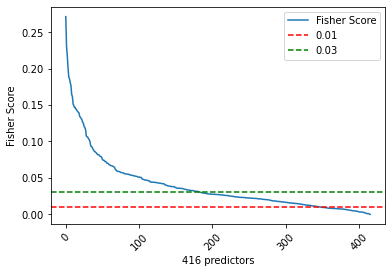

Wall time: 314 ms


In [64]:
%%time
# Visualize the Fisher Score
plt.plot(fs_df['fisherscore'].values.squeeze())
plt.axhline(y=0.01, linestyle='dashed', color='red')
plt.axhline(y=0.03, linestyle='dashed', color='green')
plt.xticks(rotation=45)
plt.xlabel(str(fs_df.shape[0]) + ' predictors')
plt.ylabel('Fisher Score')
plt.legend(['Fisher Score', '0.01', '0.03'])
plt.show()

Added # top vars : 100
Added # top vars : 200


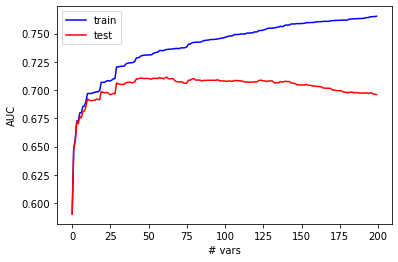

Wall time: 1min 44s


In [65]:
%%time
# Check how AUC change when add more variables: Top n vars
fs_scores = []
top_n_vars = 200
for i in range(1, top_n_vars+1):
    if i % 100 == 0: print('Added # top vars :', i)
    top_n_predictors = fs_df['predictor'][:i]
    clf = LogisticRegression()
    fs_scores.append(cross_validate(clf, train[top_n_predictors], train[target_var].values.squeeze(),
                                    scoring='roc_auc', cv=5, verbose=0, n_jobs=-1, return_train_score=True))

# How the AUC curve looks like when adding top vars
plt.plot([s['train_score'].mean() for s in fs_scores], color='blue')
plt.plot([s['test_score'].mean() for s in fs_scores], color='red')
plt.xlabel('# vars')
plt.ylabel('AUC')
plt.legend(['train', 'test'])
plt.show()

In [65]:
%%time
# Select the top variables based on Fisher Score
#top_fs_vars = fs_df[fs_df['fisherscore'] >= 0.03]['predictor'].values
top_fs_vars = fs_df['predictor'].values[:100]
print("Selected # vars :", len(top_fs_vars))
top_fs_vars

Selected # vars : 100
Wall time: 0 ns


array(['Var126_na', 'Var189', 'Var73', 'x20_6.0', 'x25_4.0', 'x36_2.0',
       'x14_3.0', 'x2_4.0', 'Var7', 'x25_5.0', 'x26_2.0', 'x33_1.0',
       'x9_6.0', 'x22_4.0', 'Var113', 'x16_10.0', 'x35_2.0', 'x29_4.0',
       'x9_4.0', 'Var65', 'Var13', 'x29_6.0', 'x7_6.0', 'x7_3.0',
       'x18_5.0', 'x18_3.0', 'x35_3.0', 'x15_9.0', 'Var144', 'x15_10.0',
       'x36_8.0', 'x15_5.0', 'x16_3.0', 'x14_2.0', 'Var126', 'x20_7.0',
       'x15_1.0', 'x24_3.0', 'Var140', 'x4_1.0', 'x6_3.0', 'x36_9.0',
       'x15_4.0', 'x26_1.0', 'x36_6.0', 'x20_8.0', 'x37_2.0', 'x8_3.0',
       'x11_1.0', 'Var81', 'x2_2.0', 'x29_3.0', 'x34_4.0', 'x35_1.0',
       'Var125', 'Var74', 'x20_2.0', 'Var72', 'x4_10.0', 'Var6',
       'x11_4.0', 'Var134', 'Var92_na', 'x12_1.0', 'x20_10.0', 'x36_7.0',
       'x24_8.0', 'Var28', 'x8_10.0', 'x31_1.0', 'x3_1.0', 'x10_1.0',
       'x29_1.0', 'x10_2.0', 'Var147', 'x34_6.0', 'Var119', 'Var109',
       'Var112', 'Var51', 'x34_9.0', 'x34_2.0', 'x24_9.0', 'x13_10.0',
       'Var173

#### (b) Dimensional Reduction: PCA

In [167]:
%%time
# Build PCA and check the explained variance
# Note: If the num vars were scaled (but the dummy were not) PVE is no longer correct
pca = PCA(n_components=200)
pca.fit(train[predictors])
print("PVE =", pca.explained_variance_ratio_.sum())
# Transform train, test
train_pca = pca.transform(train[predictors])
test_pca = pca.transform(test[predictors])

PVE = 0.7368053181938314
Wall time: 21 s


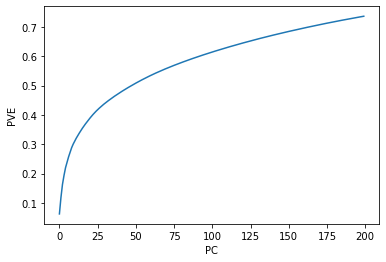

Wall time: 255 ms


In [168]:
%%time
# Visualize the PVE of PCA
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PC')
plt.ylabel('PVE')
plt.show()

In [169]:
%%time
# Reconstruct the loading vectors
loading_vecs = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_vecs = pd.DataFrame(loading_vecs,
                            columns=['PC' + str(i) for i in list(range(1, pca.n_components_+1))],
                            index=predictors)
loading_vecs.iloc[:2, :2]

Wall time: 18 ms


,PC1,PC2
Var1,-0.000024,0.000006
Var3,-0.000133,-0.000032


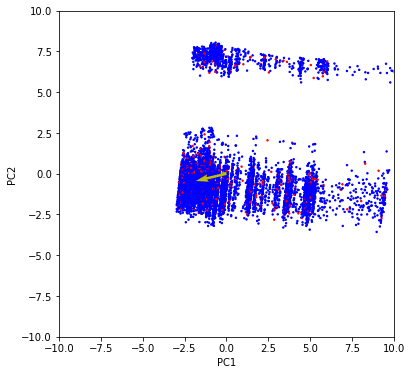

Wall time: 583 ms


In [170]:
%%time
# Visualize the group of data
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
colors = np.array(['blue'] * len(train[target_var]))
colors[train[target_var].squeeze() == 1] = 'red'
plt.scatter(x=train_pca[:, 0], y=train_pca[:, 1], color=colors, s=2)
plt.quiver([0, 0], [0, 0],
           loading_vecs.iloc[:2, :2]['PC1'].tolist(),
           loading_vecs.iloc[:2, :2]['PC2'].tolist(),
           color=['y','y'])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 3. Modeling

<u>Reference:</u>  

- Lessmann, S., Baesens, B., Seow, H. V., & Thomas, L. C. (2015). Benchmarking state-of-the-art classification algorithms for credit scoring: An update of research. European Journal of Operational Research, 247(1), 124-136.File 

In [85]:
%%time
# List of parameter tuning using cross validation for all models
model_grid = {}

Wall time: 0 ns


In [86]:
%%time
# Prepare the data, select the variable set
var_set = 'all'  # all = all vars, fs = top fisher score, pca = first PCs
if var_set == 'all':
    X = train[predictors]
    X_test = test[predictors]
    test_id = test[id_var]
elif var_set == 'fs':
    X = train[top_fs_vars]
    X_test = test[top_fs_vars]
    test_id = test[id_var]
elif var_set == 'pca':
    X = train_pca
    X_test = test_pca
    test_id = test[id_var]
y = train[target_var].values.squeeze()
print(X.shape)

# Update output file name
fname = '_' + data_prep + '_' + var_set + str(X.shape[1]) + '_' + exp_version
print(fname)

# Remove unused data
# del train, test, train_pca, test_pca

(10000, 13349)
_std_all13349_v5.3
Wall time: 939 ms


### 3.1. Modeling

#### 3.1.1. Logistic Regression

In [87]:
%%time
# Find the best parameters
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
model = LogisticRegression(max_iter=500, class_weight='balanced',
                           solver='liblinear')  # liblinear, saga
parameters = {'penalty': ['l1', 'l2'],
              'C': [0.001, 0.01, 0.1, 0.5, 1, 2]}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=10, return_train_score=True)
clf.fit(X, y)
model_grid['lr'] = clf  # Store the CV result
best_test_idx = np.where(clf.cv_results_['rank_test_score'] == 1)[0][0]
print('Best model - AUC train:', clf.cv_results_['mean_train_score'][best_test_idx])
print('Best model - AUC test:', clf.cv_results_['mean_test_score'][best_test_idx])
print("Best model - params:", clf.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  52 out of  60 | elapsed:  2.1min remaining:   19.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.3min finished


Best model - AUC train: 0.7796367020313479
Best model - AUC test: 0.7028370683782561
Best model - params: {'C': 0.1, 'penalty': 'l1'}
Wall time: 2min 25s


#### 3.1.2. Linear Discriminant Analysis

In [69]:
%%time
# Find the best parameters
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
model = LinearDiscriminantAnalysis()
parameters = {}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=10, return_train_score=True)
clf.fit(X, y)
model_grid['lda'] = clf  # Store the CV result
best_test_idx = np.where(clf.cv_results_['rank_test_score'] == 1)[0][0]
print('Best model - AUC train:', clf.cv_results_['mean_train_score'][best_test_idx])
print('Best model - AUC test:', clf.cv_results_['mean_test_score'][best_test_idx])
print("Best model - params:", clf.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Best model - AUC train: 0.7917242609329095
Best model - AUC test: 0.6695001112202685
Best model - params: {}
Wall time: 2.86 s


#### 3.1.3. Random Forest

In [70]:
%%time
# Find the best parameters
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
model = RandomForestClassifier(class_weight="balanced", random_state=1)
parameters = {'n_estimators': [100, 250, 500, 750, 1000],
              'max_features': np.round(np.sqrt(X.shape[1]*np.array([0.1, 0.25, 0.5, 1, 2, 4]))).astype(int).tolist()}
clf = GridSearchCV(model, parameters, scoring='roc_auc', n_jobs=-1, cv=cv, verbose=10, return_train_score=True)
clf.fit(X, y)
model_grid['rf'] = clf  # Store the CV result
best_test_idx = np.where(clf.cv_results_['rank_test_score'] == 1)[0][0]
print('Best model - AUC train:', clf.cv_results_['mean_train_score'][best_test_idx])
print('Best model - AUC test:', clf.cv_results_['mean_test_score'][best_test_idx])
print("Best model - params:", clf.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.6min finished


Best model - AUC train: 1.0
Best model - AUC test: 0.7027441351139003
Best model - params: {'max_features': 41, 'n_estimators': 750}
Wall time: 9min 14s


In [183]:
# Most important vars
rf_varimp = pd.DataFrame({"v":X.columns, "varimp":clf.best_estimator_.feature_importances_})
rf_varimp.sort_values(by="varimp", ascending=False).head(10)

,v,varimp
29,Var113,0.021343
201,Var81,0.018963
127,Var126,0.018847
480,Var204_woe,0.018531
10,Var73,0.017973
272,Var6,0.017631
9,Var126^2,0.017042
415,Var119,0.016178
8,Var189,0.016092
280,Var134,0.015837


#### 3.1.4. Gradient Boosting

In [184]:
%%time
# Find the best parameters
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
model = LGBMClassifier(boosting_type='gbdt', random_state=1)
parameters = {
    'objective': ['binary'],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [6, 8, 12, 16],
    'max_depth': [3, 5, 8],
    'subsample': [0.7, 0.75],
    'colsample_bytree': [0.65, 0.66],
    'n_estimators': [100],
    'reg_alpha': [1, 1.2],
    'reg_lambda': [1, 1.2, 1.4],
}
clf = GridSearchCV(model, parameters, scoring='roc_auc', n_jobs=-1, cv=cv, verbose=10, return_train_score=True)
clf.fit(X, y)
model_grid['gb'] = clf  # Store the CV result
best_test_idx = np.where(clf.cv_results_['rank_test_score'] == 1)[0][0]
print('Best model - AUC train:', clf.cv_results_['mean_train_score'][best_test_idx])
print('Best model - AUC test:', clf.cv_results_['mean_test_score'][best_test_idx])
print("Best model - params:", clf.best_params_)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Best AUC train: 0.9154082464757434
Best AUC test: 0.76872562648519
Best params: {'colsample_bytree': 0.65, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 8, 'objective': 'binary', 'reg_alpha': 1.2, 'reg_lambda': 1.4, 'subsample': 0.7}
Wall time: 17min 36s


In [185]:
# %%time
# # Find the best parameters
# cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
# model = GradientBoostingClassifier(random_state=1, validation_fraction=0.2, n_iter_no_change=10)
# parameters = {
#     'loss': ['deviance'],
#     'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#     'min_samples_split': np.linspace(0.1, 0.5, 12),
#     'min_samples_leaf': np.linspace(0.1, 0.5, 12),
#     'max_depth': [3, 5, 8],
#     'max_features':['log2', 'sqrt'],
#     'criterion': ['friedman_mse'],
#     'subsample': [0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
#     'n_estimators': [500]
# }
# clf = GridSearchCV(model, parameters, scoring='roc_auc', n_jobs=-1, cv=cv, verbose=10, return_train_score=True)
# clf.fit(X, y)
# model_grid['gb'] = clf  # Store the CV result
# best_test_idx = np.where(clf.cv_results_['rank_test_score'] == 1)[0][0]
# print('Best model - AUC train:', clf.cv_results_['mean_train_score'][best_test_idx])
# print('Best model - AUC test:', clf.cv_results_['mean_test_score'][best_test_idx])
# print("Best model - params:", clf.best_params_)

#### 3.1.5. Neural Network

In [186]:
%%time
# Find the best parameters
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
model = MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32, 16, 8),
                      learning_rate_init=0.01, max_iter=800, random_state=1)
parameters = {}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=10, return_train_score=True)
clf.fit(X, y)
model_grid['nn'] = clf  # Store the CV result
best_test_idx = np.where(clf.cv_results_['rank_test_score'] == 1)[0][0]
print('Best model - AUC train:', clf.cv_results_['mean_train_score'][best_test_idx])
print('Best model - AUC test:', clf.cv_results_['mean_test_score'][best_test_idx])
print("Best model - params:", clf.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   47.7s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   54.1s remaining:   36.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Best AUC train: 0.9999478566093716
Best AUC test: 0.7466172202426948
Best params: {}
Wall time: 2min 6s


#### Save the model parameter tuning results

In [187]:
%%time
# Save, load models
pickle.dump(model_grid, open("./out/model_grid" + fname + ".pkl", "wb"))
model_grid = pickle.load(open("./out/model_grid" + fname + ".pkl", "rb"))

Wall time: 1.14 s


### 3.2. Stacking & Voting ensemble

<u>Reference:</u>
- Ensemble methods. Link: https://scikit-learn.org/stable/modules/ensemble

In [188]:
%%time
# Available models
model_grid.keys()

Wall time: 0 ns


dict_keys(['lr', 'lda', 'rf', 'gb', 'nn'])

In [189]:
%%time
# Make prediction from all models on test
lr_pred = model_grid['lr'].best_estimator_.predict_proba(X_test)[:, 1]
lda_pred = model_grid['lda'].best_estimator_.predict_proba(X_test)[:, 1]
rf_pred = model_grid['rf'].best_estimator_.predict_proba(X_test)[:, 1]
gb_pred = model_grid['gb'].best_estimator_.predict_proba(X_test)[:, 1]
nn_pred = model_grid['nn'].best_estimator_.predict_proba(X_test)[:, 1]

Wall time: 2.91 s


In [190]:
%%time
# Aggregate the prediction of all models
agg_pred = 1/5*lr_pred + 1/5*lda_pred + 1/5*rf_pred + 1/5*gb_pred + 1/5*nn_pred
submission = pd.DataFrame({'cust_id':test_id.values.squeeze(), 'churn':agg_pred})
submission.to_csv('./out/submission_agg' + fname + '.csv', index=False)

Wall time: 66 ms


### 3.3. Debugging

To detect overfitting, underfitting problem, we can analyze the following analyses:
- Each fold of the k-fold CV
- Learning curve

#### 3.3.1. Analyze the k-fold CV

In [121]:
%%time
# Reconstruct the k-fold CV of a model with the best parameters
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
clf = Pipeline([
    #('smote', SMOTE()),
    ('clf', LGBMClassifier(boosting_type='gbdt',
                           n_estimators=500,
                           learning_rate=0.01,
                           max_depth=2,
                           class_weight='balanced',
                           subsample=0.6,
                           reg_alpha=2,
                           reg_lambda=2,
                           random_state=1,
                           n_jobs=-1))
])
scores = cross_validate(clf, X, y, scoring='roc_auc',
                        cv=cv, n_jobs=-1, verbose=10, return_train_score=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.8s remaining:   35.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   23.9s remaining:   15.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.2s finished


Wall time: 24.6 s


In [192]:
# %%time
# # Reconstruct the k-fold CV of a model with the best parameters
# cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
# clf = Pipeline([
#     #('smote', SMOTE()),
#     ('clf', GradientBoostingClassifier(criterion='friedman_mse',
#                                        learning_rate=0.01,
#                                        loss='deviance',
#                                        max_depth=3,
#                                        max_features='sqrt',
#                                        min_samples_leaf=0.1,
#                                        #min_samples_split=0.3,
#                                        n_estimators=500,
#                                        subsample=0.9,
#                                        random_state=1,
#                                        validation_fraction=0.2,
#                                        n_iter_no_change=50))
# ])
# scores = cross_validate(clf, X, y, scoring='roc_auc',
#                         cv=cv, n_jobs=-1, verbose=10, return_train_score=True)

In [122]:
%%time
# Print out the k-fold CV on train, test to analyze
scores_df = pd.DataFrame({'train':scores['train_score'],
                          'test':scores['test_score']})
scores_df

Wall time: 0 ns


,train,test
0,0.772751,0.744404
1,0.782422,0.722261
2,0.779932,0.726270
3,0.780597,0.716953
4,0.777714,0.743435


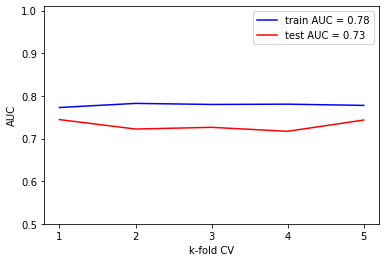

Wall time: 250 ms


In [123]:
%%time
# Visualize the train, test score
plt.plot(scores_df['train'], color='blue')
plt.plot(scores_df['test'], color='red')
plt.ylim(0.5, 1.01)
plt.xticks(scores_df.index, scores_df.index+1)
plt.xlabel('k-fold CV')
plt.ylabel('AUC')
plt.legend(('train AUC = ' + str(np.round(scores_df['train'].mean(), 2)),
            'test AUC = ' + str(np.round(scores_df['test'].mean(), 2))))
plt.show()

#### 3.3.2. Analyze the learning curve

<u>Reference:</u>
- Plotting Learning Curves. Link: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [195]:
%%time
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, scoring=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

Wall time: 0 ns


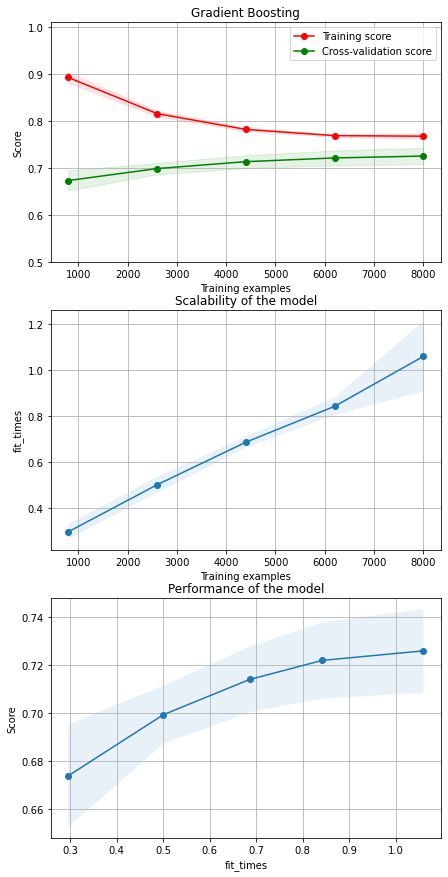

Wall time: 12.7 s


In [196]:
%%time
# Plot the learning curve
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
title = "Gradient Boosting"
fig, axes = plt.subplots(3, 1, figsize=(7, 15))
plot_learning_curve(clf, title, X, y, axes=axes, ylim=(0.5, 1.01),
                    cv=cv, n_jobs=4, scoring='roc_auc')
plt.show()

#### 3.3.3. Check the dissimilarity between train, test (covariate shift)

<u>Reference:</u>
- How (dis)similar are my train and test data? Link: https://towardsdatascience.com/how-dis-similar-are-my-train-and-test-data-56af3923de9b

In [89]:
%%time
# Combine train, test data and prepare the target is_train = [0, 1]
X_all = pd.concat([X, X_test])
y_is_train = np.array(X.shape[0] * [1] + X_test.shape[0] * [0])

Wall time: 1.47 s


In [90]:
%%time
# k-fold CV of the model to predict train, test data
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
clf_is_train = RandomForestClassifier()
scores = cross_validate(clf_is_train, X_all, y_is_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=10)
print('AUC cv:', scores['test_score'].mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.6min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


AUC cv: 0.5020610249999999
Wall time: 2min 39s


## 4. Make prediction

Use the best model to make prediction on test set. Submit the result to Kaggle.

In [124]:
%%time
# Make prediction using a model
final_model = 'gb'
#pred = model_grid[final_model].best_estimator_.predict_proba(X_test)[:, 1]
pred = clf.fit(X, y).predict_proba(X_test)[:, 1]
submission = pd.DataFrame({'cust_id':test_id.values.squeeze(), 'churn':pred})
submission.to_csv('./out/submission_' + final_model + fname + '.csv', index=False)
submission.head()

Wall time: 17.5 s


,cust_id,churn
0,1,0.624887
1,2,0.497828
2,5,0.648022
3,6,0.641101
4,10,0.595436


## 5. Other useful references

1. Dynamic Classifier Selection Ensembles in Python. Link: https://machinelearningmastery.com/dynamic-classifier-selection-in-python/
2. How to Develop a Feature Selection Subspace Ensemble in Python. Link: https://machinelearningmastery.com/feature-selection-subspace-ensemble-in-python/
3. How to Choose a Feature Selection Method For Machine Learning. Link: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/